# **ML vs SML vs Time Series Analysis**

N.B. Some variables will be declared in all uppercase, this means that these variables will be reuse during different sections of the notebook.

In [1]:
# Loading the dataset
import os
import pandas as pd

# Load the dataset
data = pd.read_csv(os.path.join('data', 'day.csv'))

In [2]:
############ BASIC PREPROCESSING  ############

# Convert the date column to a datetime object
data['dteday'] = pd.to_datetime(data['dteday'])
# Set the date column as the index
data.set_index('dteday', inplace=True)
# Remove unnecessary labels ("registered, "casual", and "instant")
DATA = data.drop(['casual', 'registered', 'instant'], axis=1)
# Extract the features names
FEATURES = DATA.columns[:-1]
# Define the target variable
LABEL = 'cnt'

## **Features of the datasets**

Here we have reported the features that are present in the original datasets.
The features are divided in two big categories: the first "Time Features" collects everything that specify the time of which that specific data point is referring to, while the second category "Atmospheric Features" group all the information available about the weather, temperature, and humidity at a specific time/date.

<style>
* {
  box-sizing: border-box;
}

.row {
  margin-left:-5px;
  margin-right:-5px;
}
  
.column {
  float: left;
  width: 50%;
  padding: 50px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}

table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  border: 1px solid #ddd;
}

th, td {
  text-align: left;
  padding: 16px;
}

</style>
</head>
<body>

<div class="row">
  <div class="column">
    <center><b>Time Features</b></center>
    <table>
      <tr>
        <th><center>Feature name</center></th>
        <th><center>Description</center></th>
      </tr>
      <tr>
        <td><center>dteday</center></td>
        <td>Full date (yyyy-mm-dd)</td>
      </tr>
      <tr>
        <td><center>season</center></td>
        <td>Season (1: Spring, 2: Summer, 3: Fall, 4: Winter)</td>
      </tr>
      <tr>
        <td><center>yr</center></td>
        <td>Year (0: 2011, 1:2012)</td>
      </tr>
      <tr>
        <td><center>mnth</center></td>
        <td>Month (1 to 12)</td>
      </tr>
      <tr>
        <td><center>holiday</center></td>
        <td>Day is holiday or not</td>
      </tr>
      <tr>
        <td><center>weekday</center></td>
        <td>Day of the week (0 to 7)</td>
      </tr>
      <tr>
        <td><center>workingday</center></td>
        <td>If day is neither weekend nor holiday is 1, otherwise is 0</td>
      </tr>
    </table>
  </div>
  <div class="column">
    <center><b>Atmospheric Features</b></center>
    <table>
      <tr>
        <th><center>Feature name</center></th>
        <th><center>Description</center></th>
      </tr>
      <tr>
        <td><center>weathersit</center></td>
        <td>Type of weather of the day/hour (Clear, Cloudy, Rain, etc...)</td>
      </tr>
      <tr>
        <td><center>temp</center></td>
        <td>Normalized temperature in Celsius. The values are divided to 41 (max)</td>
      </tr>
      <tr>
        <td><center>atemp</center></td>
        <td>Normalized feeling temperature in Celsius. The values are divided to 50 (max)</td>
      </tr>
      <tr>
        <td><center>hum</center></td>
        <td>Normalized humidity. The values are divided to 100 (max)</td>
      </tr>
      <tr>
        <td><center>windspeed</center></td>
        <td>Normalized wind speed. The values are divided to 67 (max)</td>
      </tr>
    </table>
  </div>
</div>

</body>
</html>

Our problem is trying to predict how many customer will take a bike on a specific date, thus our target variable is **cnt** (that is the count of total rental bikes including both casual and registered).<br>
We also have available the breakdown between how many bikes were rented by casual or registered customers, but we will not focus on that in this notebook. An interesting exercise could be repeat everything that we're going to do focusing only on registered customers or casual ones.

## **Some visualization**

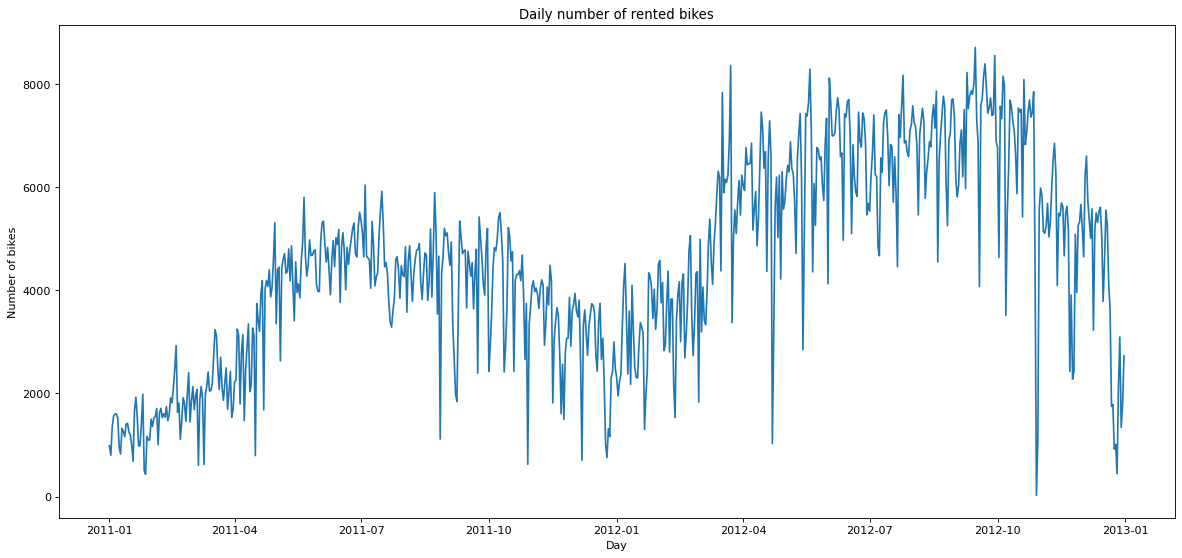

In [3]:
import matplotlib.pyplot as plt

def plot_data(data, title: str, x_axis: str, y_axis: str):
    plt.figure(figsize=(18, 8), dpi=80)
    
    # Create a line plot of the time series
    if type(data) != list:
        plt.plot(data[LABEL])
    else:
        for block in data:
            plt.plot(block[LABEL])

    # Add custom title to the plot
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    # Show the plot
    plt.show()

plot_data(DATA, "Daily number of rented bikes", "Day", "Number of bikes")

## **How to compare the streaming approach to the traditional one?**

As in any good Machine Learning pipeline, to be confident in our final results we can't simply define a single split between train and test set, and call it a day. This modus operandi will lead us to biased results, thus we have the necessity of using some kind of cross-validation. Generally, k-folds cross-validation is the easiest and best choice, but does is really makes sense with our dataset?

Well... not in its standard form. If we simply sampled at random our dataset to form k folds, we would end up destroying the time-relation between the data points. Thus, we need to find another way that makes more sense.

What we are going to do is to create k blocks of **consecutive** data points. Then, we are going to use these blocks to do some **incremental backtesting**. This techniques is simple, but really effective when dealing with time series: the idea is that, given N data blocks, we first train on block [0] and test on block [1], then we train on blocks [0,1] and test on block [2], etc...

<style>
  .responsive-image {
    max-width: 80%;
    height: auto;
  }
</style>

<img class="responsive-image" src="data/cv_ts.png" alt="Cross-validation visualization">

Now that we've enstablished how we will evaluate all of out models, we need to create these blocks!
We will divide all the dataset is 24 blocks, that roughly correspond to one month each.

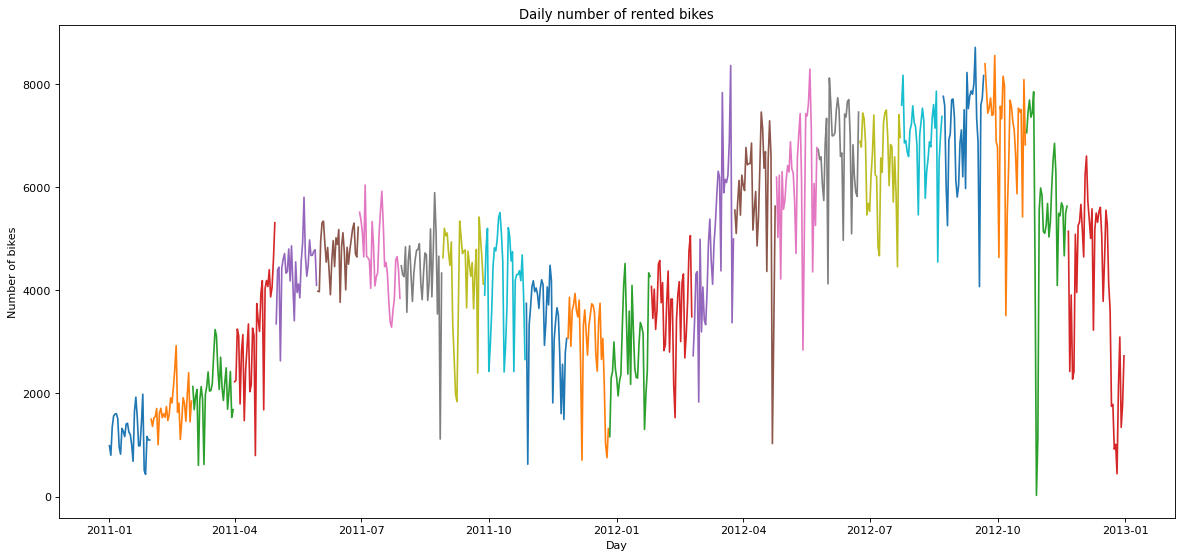

In [4]:
# Define how many data blocks we  have
NUM_BLOCKS = 24

# Create the 5 block of data
block_length = int(round(len(DATA) / NUM_BLOCKS, 0))
BLOCKS = []
base_idx = 0
for _ in range(NUM_BLOCKS-1):
    BLOCKS.append(DATA.iloc[base_idx:base_idx+block_length, :])
    base_idx += block_length
BLOCKS.append(DATA.iloc[base_idx:, :])

plot_data(BLOCKS, "Daily number of rented bikes", "Day", "Number of bikes")

## **Let's enstablish a baseline**

The first step when we are training multiple models, is to enstablish a baseline performance. This will help us put into perspective the results of each approach to our problem. 

We will use mainly 3 metrics to evaluate our models:
- *MAE* (Mean Absolute Error)
- *RMSE* (Root Mean Square Error)
- *R<sup>2</sup>* (R Squared)

There are multiple naive ways to implement a simple baseline for a time series, but we will simply predict **y<sub>t+1</sub> = y<sub>t</sub>**, given that generally this is the simplest and best method. Furthermore, in order to compare the performance of the traditional ML approach (based on periodic re-training over N data blocks) with the others, we will also take N-1 snapshots of the cumulative performance of SML models that corresponds to the end of each of the N-1 blocks used for testing.

In [5]:
import numpy as np

def plot_metrics(metrics):
    mae, rmse, r2 = zip(*metrics)
    max_len = len(mae)

    plt.figure(figsize=(20, 4), dpi=80)

    plt.subplot(1, 3, 1)
    plt.plot(mae, marker='o')
    plt.title('MAE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))
    
    plt.subplot(1, 3, 2)
    plt.plot(rmse, marker='o')
    plt.title('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))

    plt.subplot(1, 3, 3)
    plt.plot(r2, marker='o')
    plt.title('R2')
    plt.xlabel('Block')
    plt.xticks(range(max_len), range(1, max_len+1))

    plt.show()

def evaluate_final(metrics):
    maes, rmses, r2s = zip(*metrics)

    print('Final performance\n')
    print(f'MAE')
    print(f'  - Mean:  {np.mean(maes)}')
    print(f'  - Stdev: {np.std(maes)}')
    print(f'RMSE')
    print(f'  - Mean:  {np.mean(rmses)}')
    print(f'  - Stdev: {np.std(rmses)}')
    print(f'R2')
    print(f'  - Mean:  {np.mean(r2s)}')
    print(f'  - Stdev: {np.std(r2s)}')
    print("*"*35)

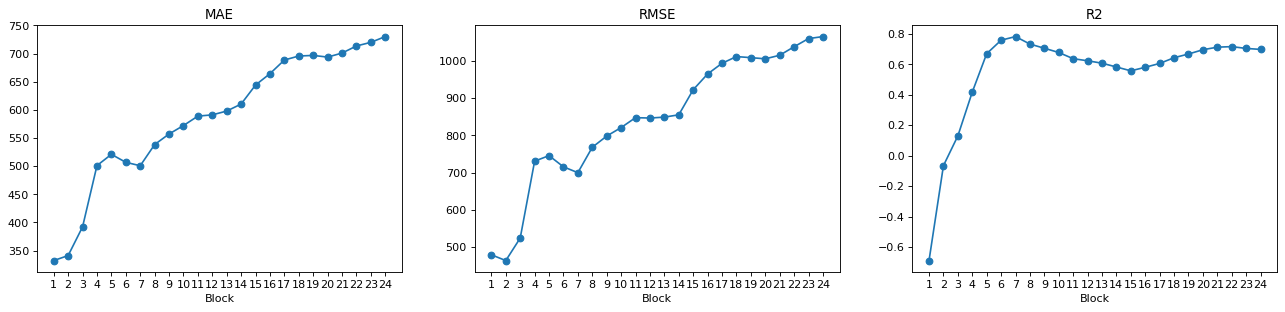

Final performance

MAE
  - Mean:  587.4676595526402
  - Stdev: 114.57621127325233
RMSE
  - Mean:  842.4787554232661
  - Stdev: 174.6500210547076
R2
  - Mean:  0.5477495445477321
  - Stdev: 0.32004899679067483
***********************************


In [6]:
from river.stream import iter_pandas
from river.metrics import MAE, RMSE, R2

# Metrics
mae = MAE()
rmse = RMSE()
r2 = R2()

# First, we create a stream using the full dataset frame
stream = iter_pandas(X=data[FEATURES], y=data[LABEL])

# Now it's time to "train" and evaluate the "model"
y_old, idx = 0, 0
metrics = []
for block in BLOCKS:
    for xi, yi in iter_pandas(X=block[FEATURES], y=block[LABEL]):
        #  Update the continuos metrics
        mae.update(y_true=yi, y_pred=y_old)
        rmse.update(y_true=yi, y_pred=y_old)
        r2.update(y_true=yi, y_pred=y_old)
        
        y_old = yi
    # Record a snapshot of all metrics at the end of the block
    metrics.append((mae.get(), rmse.get(), r2.get()))

plot_metrics(metrics)
evaluate_final(metrics)

## **Traditional Machine Learning**

In this section we will explore the performance of traditional machine learning models when used to solve a time series regression task.

We will check 3 different models:
- KNN
- Decision Tree
- Random Forest

In [7]:
# This special plot function will let us compare the summary results for all the models in each approach

def cross_compare(metric_list: list, names: list):
    plt.figure(figsize=(15 if len(names)>2 else 12, 4), dpi=80)

    maes, rmses, r2s = [], [], []
    for metrics in metric_list:
        mae, rmse, r2 = zip(*metrics)
        maes.append((np.mean(mae), np.std(mae)))
        rmses.append((np.mean(rmse), np.std(rmse)))
        r2s.append((np.mean(r2), np.std(r2)))

    for id, (data, metric) in enumerate([(maes, 'MAE'), (rmses, 'RMSE'), (r2s, 'R2')]):
        plt.subplot(1, 3, id+1)
        means, stdevs = zip(*data)
        plt.bar(names, means, yerr=stdevs, capsize=6, color=['royalblue', 'dodgerblue', 'darkturquoise', 'black'])
        plt.title(metric)

    plt.show()

In [8]:
#########   EVALUATION METHODS   #########
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a simple function to evaluate all ml models
def evaluate_ml(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return (mae, rmse, r2)

In [9]:
#########   TRAIN & TEST METHOD   #########

def train_and_test_ml(model):
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # Train the model
        model.fit(X=train[FEATURES], y=train[LABEL])
        # Test the model
        y_pred = model.predict(X=block[FEATURES])
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics


### *KNN*

This specific algorithm is a lazy learner: the algorithm doesn't really learn any data representation or model, it simply memorizes all the data sent in input to later compare it to new data.

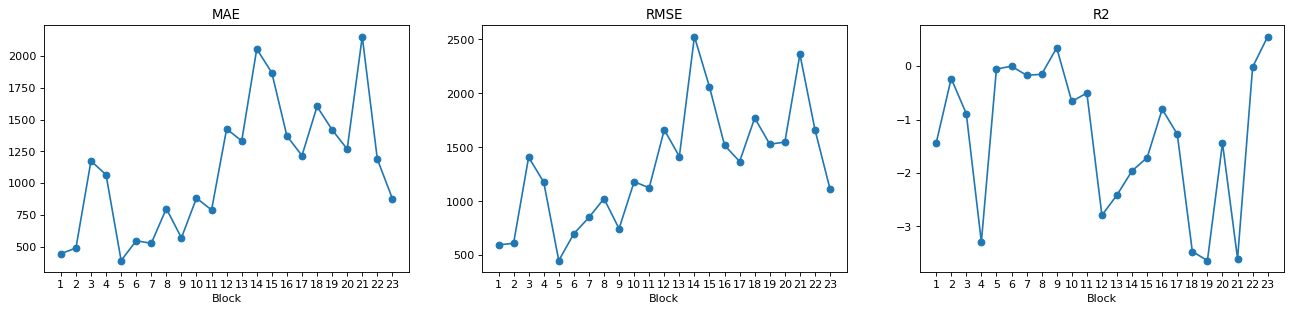

Final performance

MAE
  - Mean:  1106.7552067868503
  - Stdev: 500.23698471791056
RMSE
  - Mean:  1321.8639779091657
  - Stdev: 536.3765439345575
R2
  - Mean:  -1.2890200217644325
  - Stdev: 1.3170884360600243
***********************************


In [10]:
from sklearn.neighbors import KNeighborsRegressor

# Instantiate model
knn = KNeighborsRegressor()
# Train and test the model
knn_metrics = train_and_test_ml(knn)
# Plot the obtained metrics
plot_metrics(knn_metrics)
# Evaluate the model
evaluate_final(knn_metrics)


### *Decision Tree*

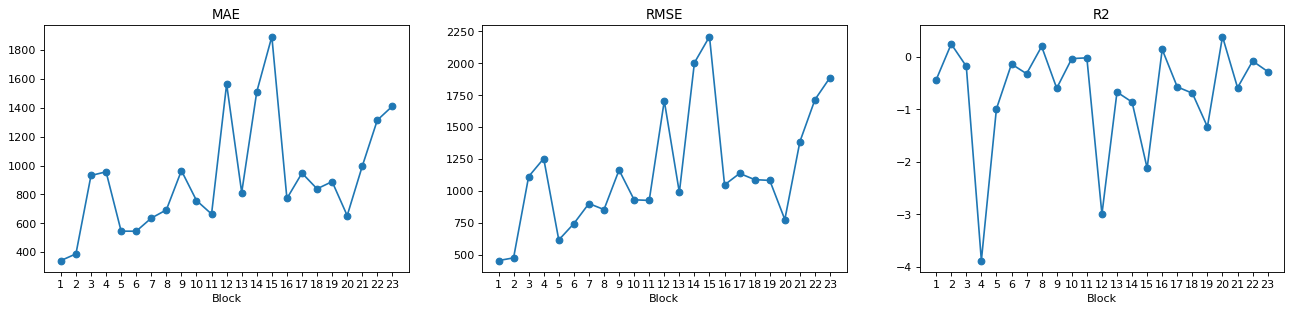

Final performance

MAE
  - Mean:  914.3404288778559
  - Stdev: 381.6513816221691
RMSE
  - Mean:  1151.9384405083674
  - Stdev: 461.47277683634815
R2
  - Mean:  -0.6897169758573292
  - Stdev: 1.0168757429949888
***********************************


In [11]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate model
decision_tree = DecisionTreeRegressor(max_depth=12)
# Train and test the model
tree_metrics = train_and_test_ml(decision_tree)
# Plot the obtained metrics
plot_metrics(tree_metrics)
# Evaluate the model
evaluate_final(tree_metrics)

### *Random Forest*

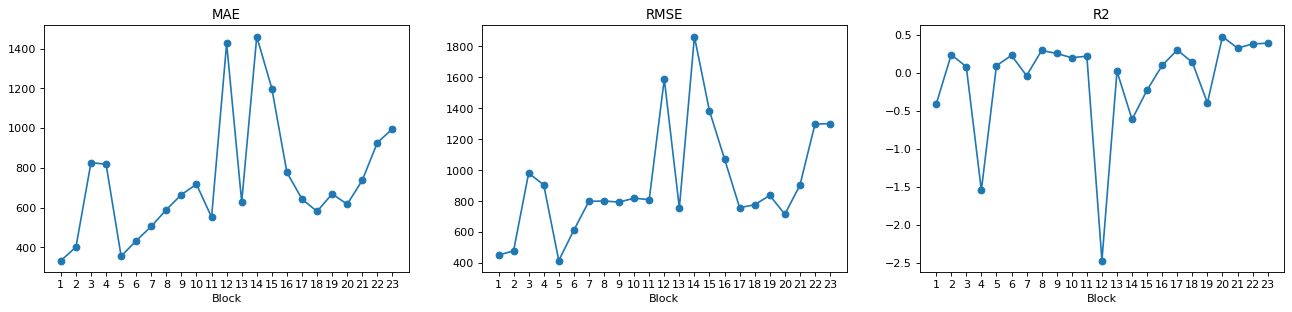

Final performance

MAE
  - Mean:  733.0027097914458
  - Stdev: 296.6399948224663
RMSE
  - Mean:  918.7114226319184
  - Stdev: 349.91958508015415
R2
  - Mean:  -0.08368372367351916
  - Stdev: 0.6649875166258186
***********************************


In [12]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rand_forest = RandomForestRegressor()
# Train and test the model
forest_metrics = train_and_test_ml(rand_forest)
# Plot the obtained metrics
plot_metrics(forest_metrics)
# Evaluate the model
evaluate_final(forest_metrics)

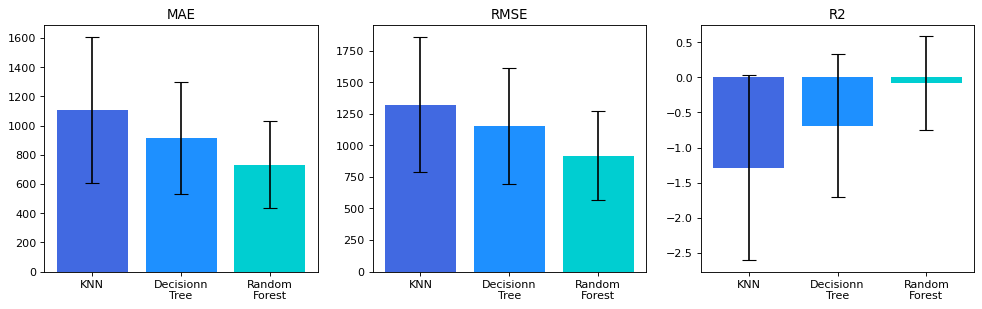

In [13]:
cross_compare((knn_metrics, tree_metrics, forest_metrics), ('KNN', 'Decisionn\nTree', 'Random\nForest'))

## **Streaming Machine Learning**

- KNN with limited data window
- Hoeffding Adaptive Tree
- Adaptive Random Forest

In [14]:
#########   EVALUATION METHODS   #########

# Define a simple function to evaluate all ml models
def evaluate_sml(y_true, y_pred, metrics):
    mae, rmse, r2 = metrics
    mae.update(y_true=y_true, y_pred=y_pred)
    rmse.update(y_true=y_true, y_pred=y_pred)
    r2.update(y_true=y_true, y_pred=y_pred)

In [15]:
#########   TRAIN & TEST METHOD   #########
def _train_sml(model, train, metrics, continuos_metrics):
    mae, rmse, r2 = metrics
    for xi, yi in iter_pandas(X=train[FEATURES], y=train[LABEL]):
        # Evaluate the single data point
        y_pred = model.predict_one(x=xi)
        # Update the metrics
        evaluate_sml(y_true=yi, y_pred=y_pred, metrics=metrics)
        # Record the continuous metrics
        continuos_metrics.append((mae.get(), rmse.get(), r2.get()))
        # Learn from the new data point
        model.learn_one(x=xi, y=yi)

def train_and_test_sml(model):
    # Metrics
    mae = MAE()
    rmse = RMSE()
    r2 = R2()

    metrics, continuos_metrics = [], []
    for block_idx in range(len(BLOCKS)-1):
        # Get the block used for training
        train = BLOCKS[block_idx]
        # Train the model over the current block
        _train_sml(model, train, (mae, rmse, r2), continuos_metrics)
        # Now we evaluate the model the same as if it was a ML model
        test = BLOCKS[block_idx+1]
        predictions, truths = [], []
        for xi, yi in iter_pandas(X=test[FEATURES], y=test[LABEL]):
            # Evaluate the single data point
            y_pred = model.predict_one(x=xi)
            # Record the prediction and the ground truth
            predictions.append(y_pred)
            truths.append(yi)
        metrics.append(evaluate_ml(truths, predictions))
    
    # We also train over the last block to have the full curve of the continuos metrics
    _train_sml(model, BLOCKS[-1], (mae, rmse, r2), continuos_metrics)    

    return metrics, continuos_metrics

In [16]:
def plot_sml(data, title: str, x_axis: str, y_axis: str):
    plt.figure(figsize=(16, 4), dpi=80)
    plt.plot(data)

    # Add custom title to the plot
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    # Show the plot
    plt.show()

### *KNN with limited data window*

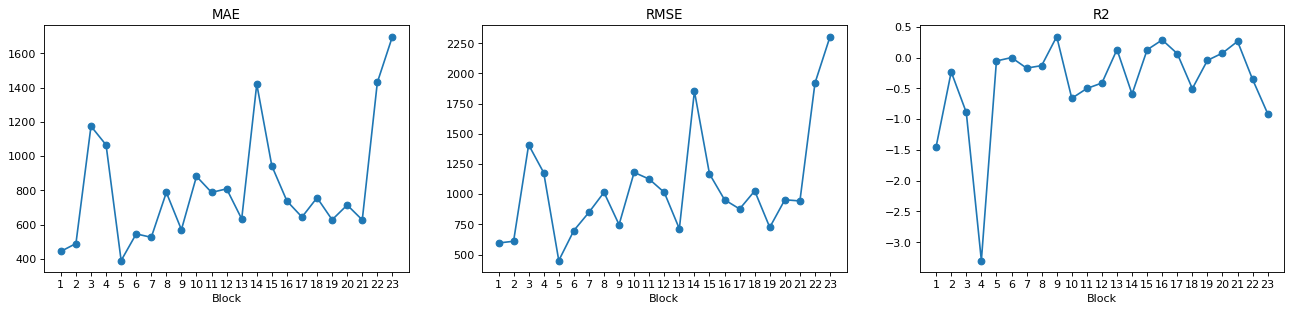

Final performance

MAE
  - Mean:  813.8580063626724
  - Stdev: 331.41213740533476
RMSE
  - Mean:  1057.1121673822956
  - Stdev: 440.2286884426992
R2
  - Mean:  -0.38733160235345826
  - Stdev: 0.7560338523397281
***********************************


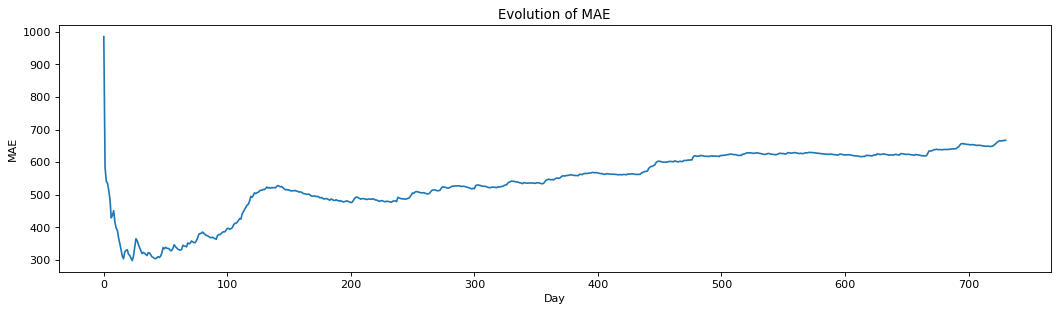

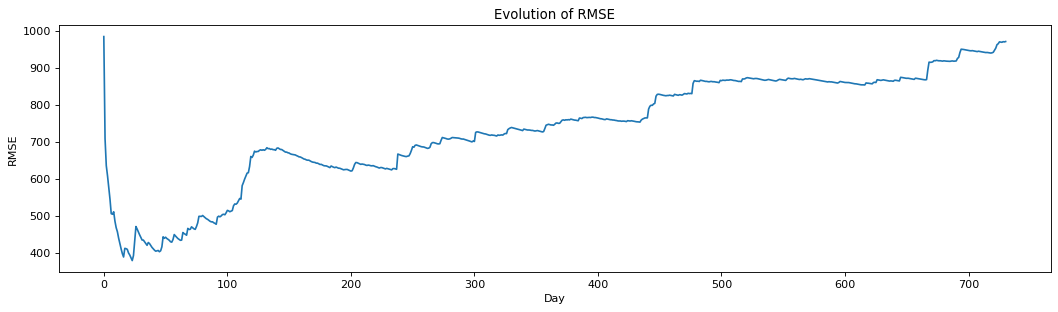

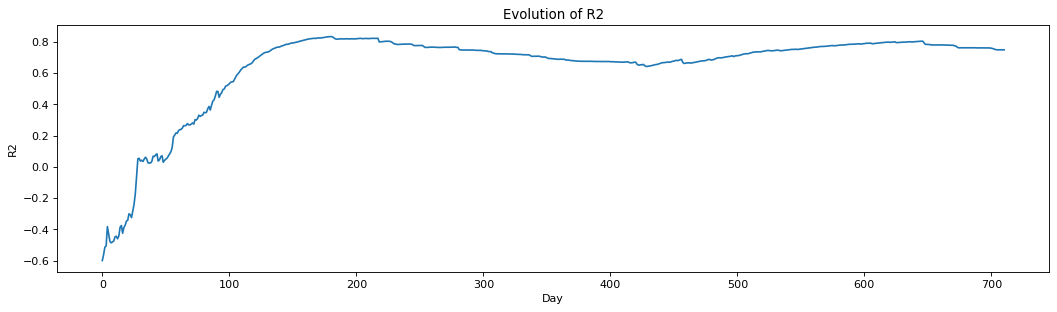

In [17]:
from river.neighbors import KNNRegressor

# Instantiate the model
stream_knn = KNNRegressor(window_size=50)
# Train and test the model
stream_knn_metrics, knn_continuos_metrics = train_and_test_sml(stream_knn)
# Plot the obtained metrics
plot_metrics(stream_knn_metrics)
# Evaluate the model
evaluate_final(stream_knn_metrics)
# Plot the continuous metrics
stream_knn_maes, stream_knn_rmses, stream_knn_r2s = zip(*knn_continuos_metrics)
plot_sml(stream_knn_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(stream_knn_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(stream_knn_r2s[20:], 'Evolution of R2', 'Day', 'R2')

### *Hoeffding Adaptive Tree*

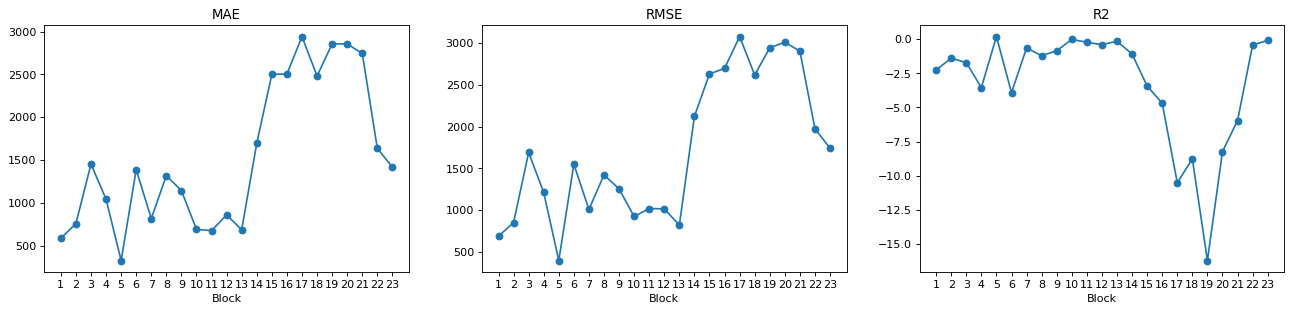

Final performance

MAE
  - Mean:  1537.5492144496511
  - Stdev: 843.8032709903264
RMSE
  - Mean:  1720.908945255249
  - Stdev: 843.2390494999906
R2
  - Mean:  -3.2898689463530073
  - Stdev: 4.0728135371813385
***********************************


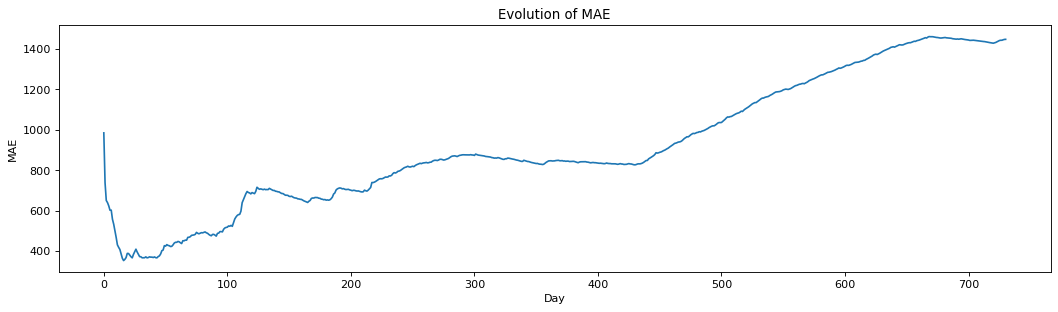

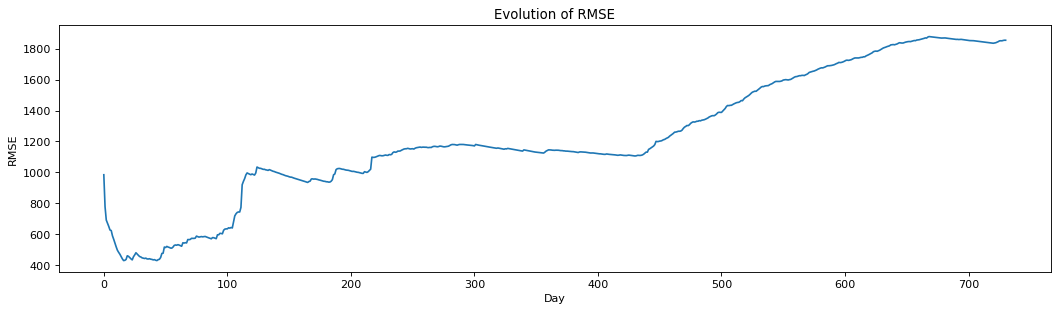

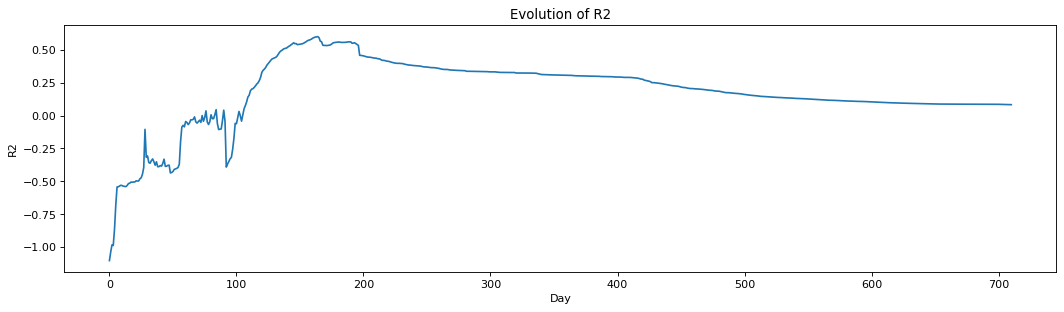

In [18]:
from river.tree import HoeffdingAdaptiveTreeRegressor

# Instantiate the model
hat = HoeffdingAdaptiveTreeRegressor()
# Train and test the model
hat_metrics, hat_continuos_metrics = train_and_test_sml(hat)
# Plot the obtained metrics
plot_metrics(hat_metrics)
# Evaluate the model
evaluate_final(hat_metrics)
# Plot the continuous metrics
hat_maes, hat_rmses, hat_r2s = zip(*hat_continuos_metrics)
plot_sml(hat_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(hat_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(hat_r2s[20:], 'Evolution of R2', 'Day', 'R2')

### *Adaptive Random Forest*

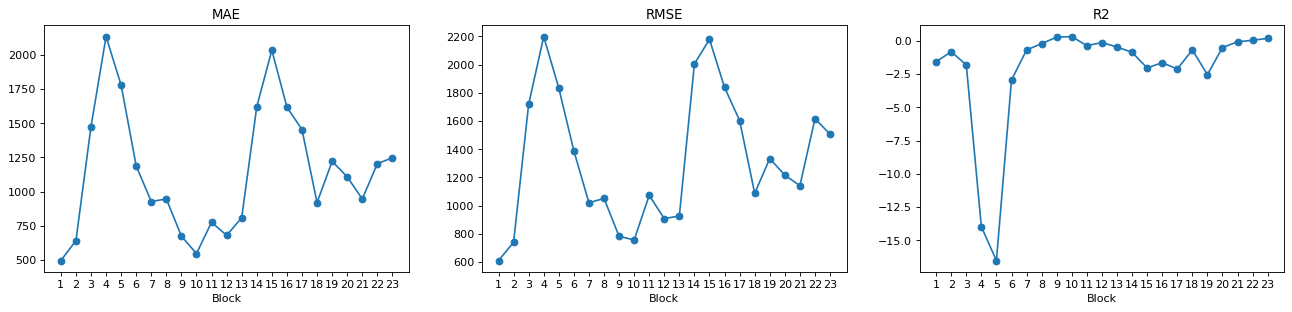

Final performance

MAE
  - Mean:  1150.170363556992
  - Stdev: 453.97111148167284
RMSE
  - Mean:  1327.706113245091
  - Stdev: 464.31816085602134
R2
  - Mean:  -2.1368516684532715
  - Stdev: 4.1608746577291225
***********************************


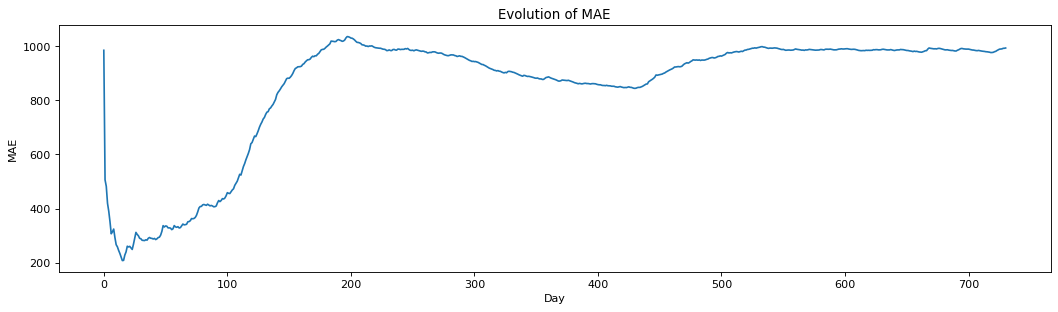

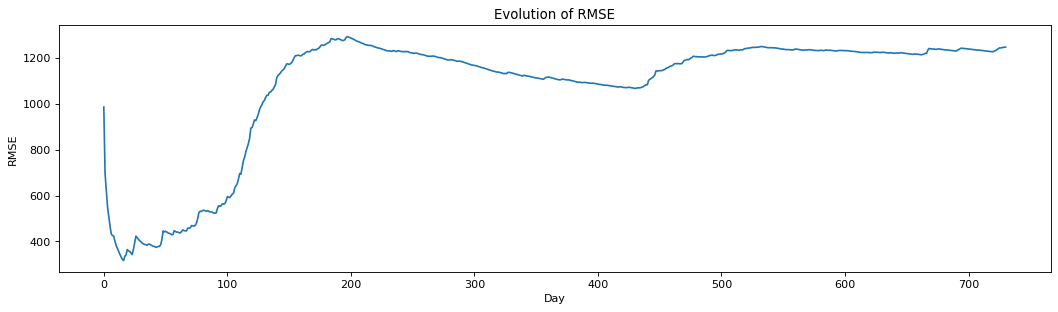

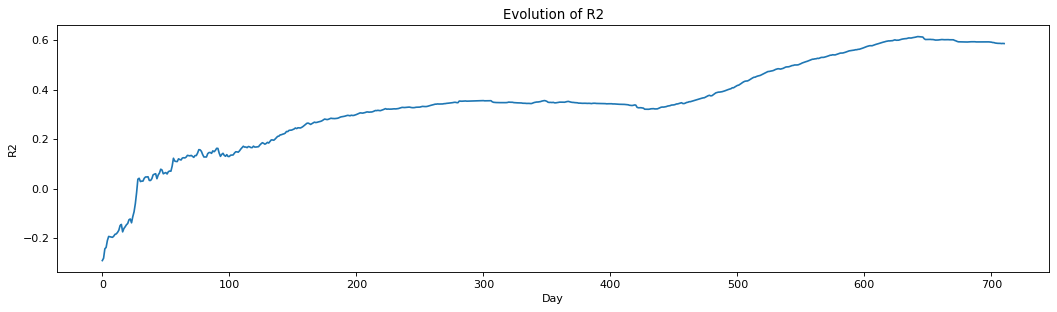

In [19]:
from river.ensemble import AdaptiveRandomForestRegressor

# Instantiate the model
arf = AdaptiveRandomForestRegressor(n_models=20)
# Train and test the model
arf_metrics, arf_continuos_metrics = train_and_test_sml(arf)
# Plot the obtained metrics
plot_metrics(arf_metrics)
# Evaluate the model
evaluate_final(arf_metrics)
# Plot the continuous metrics
arf_maes, arf_rmses, arf_r2s = zip(*arf_continuos_metrics)
plot_sml(arf_maes, 'Evolution of MAE', 'Day', 'MAE')
plot_sml(arf_rmses, 'Evolution of RMSE', 'Day', 'RMSE')
plot_sml(arf_r2s[20:], 'Evolution of R2', 'Day', 'R2')

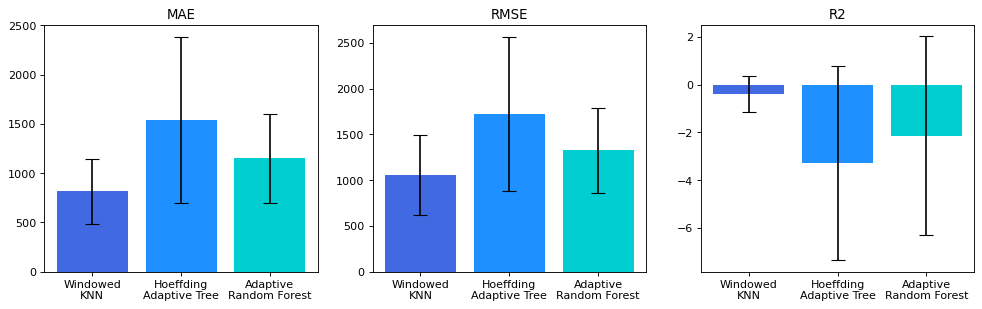

In [20]:
cross_compare((stream_knn_metrics, hat_metrics, arf_metrics), ('Windowed\nKNN', 'Hoeffding\nAdaptive Tree', 'Adaptive\nRandom Forest'))

## **Time series Analysis**

- Holt-Winters
- SARIMA

### *Holt-Winters*

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing

def get_Holt_Winters(data, seasonal_period=7, trend='mul', seasonal='mul'):
    return ExponentialSmoothing(data,
                              seasonal_periods=seasonal_period,
                              trend=trend, 
                              seasonal=seasonal,
                              use_boxcox=True,
                              initialization_method="estimated")

def train_and_test_hw(seasonal_period=7, trend='mul', seasonal='mul'):
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # Instantiate the model
        model = get_Holt_Winters(train[LABEL], seasonal_period, trend, seasonal)
        # Fit the data
        model = model.fit()
        # Test the model
        y_pred = model.forecast(len(block) // 4)
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL][:len(block) // 4], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics

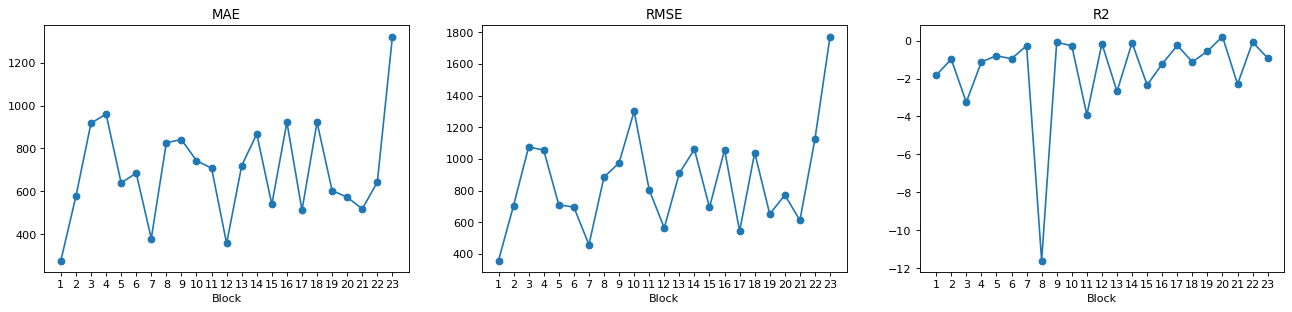

Final performance

MAE
  - Mean:  698.1800655357616
  - Stdev: 228.94341375939024
RMSE
  - Mean:  862.9314619973846
  - Stdev: 304.01802969725384
R2
  - Mean:  -1.5945074301092454
  - Stdev: 2.388317869918527
***********************************


In [22]:
import warnings
warnings.simplefilter('ignore')

# Train and test
holt_winters_metrics = train_and_test_hw(seasonal_period=14)
# Plot the obtained metrics
plot_metrics(holt_winters_metrics)
# Evaluate the model
evaluate_final(holt_winters_metrics)

### *SARIMA*

In [23]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_and_test_sarima():
    idx = 1
    metrics = []
    train = BLOCKS[0]
    for block in BLOCKS[1:]:
        # First, we find the correct parameters using auto_arima
        # But we also cycle through the posssible seasonalities (daily = 7, monthly = 12, weekly = 52)
        idx += 1
        results = []
        for seasonality in [7, 12, 52]:
            try:
                arima = auto_arima(train[LABEL], trace=False, error_action='ignore', suppress_warnings=True, seasonal=True, m=seasonality)
                results.append(arima)
            except:
                pass

        # Obtain the best posible parameters
        best_params = sorted(results, key=lambda x: x.aic(), reverse=True)[0].get_params()
        # Instantiate the model
        model = SARIMAX(train[LABEL], order = best_params['order'], seasonal_order = best_params['seasonal_order'])
        # Fit the data
        model = model.fit()
        # Test the model
        y_pred = model.predict(start=len(train), end=(len(train)+len(block)//4-1), dynamic=False)
        # Evaluate the model
        metrics.append(evaluate_ml(block[LABEL][:len(block) // 4], y_pred))

        # Now we expand the training dataset
        train = pd.concat([train, block], axis=0)

    return metrics

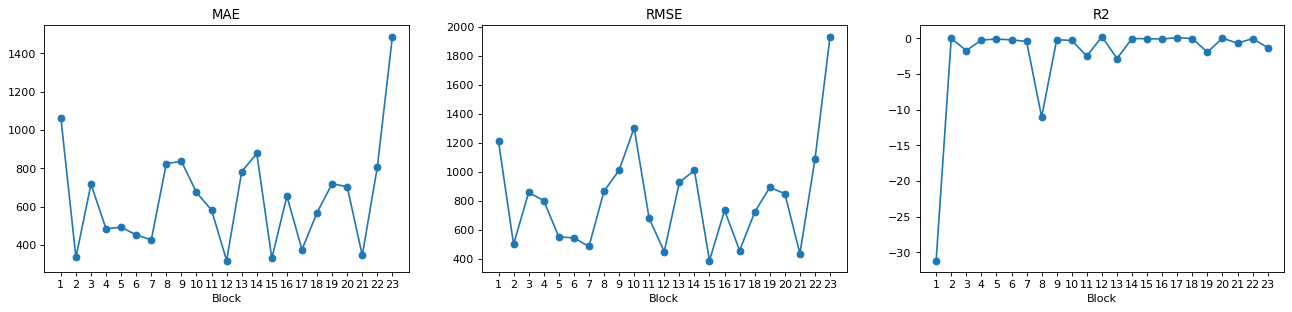

Final performance

MAE
  - Mean:  646.6885989876495
  - Stdev: 269.7009745601667
RMSE
  - Mean:  811.9781397236035
  - Stdev: 348.6629321988471
R2
  - Mean:  -2.350183219257405
  - Stdev: 6.552698220567172
***********************************


In [24]:
# Train and test
sarima_metrics = train_and_test_sarima()
# Plot the obtained metrics
plot_metrics(sarima_metrics)
# Evaluate the model
evaluate_final(sarima_metrics)

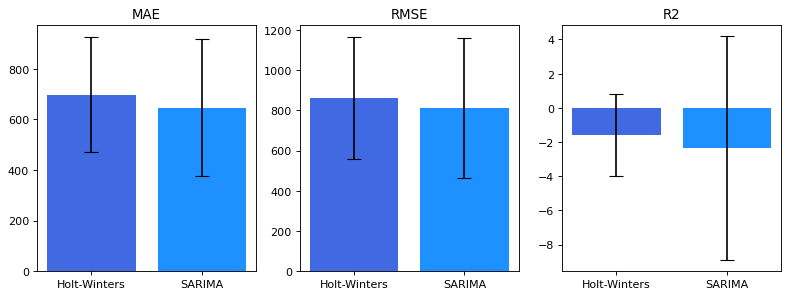

In [25]:
cross_compare((holt_winters_metrics, sarima_metrics), ('Holt-Winters', 'SARIMA'))